In [1]:
from DL_Methods.MS_AE.ms_autoencoder import GraphEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.cluster import normalized_mutual_info_score
from torch import nn, optim
import torch
import numpy as np
from tqdm import tqdm
import networkx as nx
import Utils
import Plotting

#Make reproducible results
SEED = 0
torch.manual_seed(SEED)
np.random.seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


cpu


In [15]:
data_folder = '/Users/ryznerf/Documents/0_MIT/Spring_2022/0_Projects/3_Networks_project/community-detetction-deep-learning/Data/'
files = ['toy_dataset.pkl', 'complex_1.pkl', 'complex_2.pkl']

In [17]:
# CASE 1
g = Utils.unpickle_object(data_folder + files[0])

#Preprocessing
X = np.asarray(nx.to_numpy_matrix(g))
partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster}
Y = np.array(list(partition_true.values()))
k = len(np.unique(Y))

#Wine dataset: Original Implementation
'''
from sklearn.datasets import load_wine
from sklearn import preprocessing

data = load_wine()
X = data.data
Y = data.target
k = len(np.unique(Y))

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
'''

S = cosine_similarity(X, X)


#Should this be X.sum or S.sum ? From Github Implementation
D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
X_train = torch.tensor(D.dot(S).dot(D)).float().to(device)

#My Reading of the Paper
'''
D = np.diag(X.sum(axis=1))
X_train = np.linalg.inv(D) @ S
X_train = torch.tensor(X_train).float().to(device)
'''


epochs = 500
beta = 0   #Unregularized works best. Maybe the KL divergence implementation is flawed
rho = 0.5 #paper had 0.01
lr = 1e-4

#First cycle
layers = [len(X_train)] + [512, 256, 512] + [len(X_train)]
model = GraphEncoder(layers, k).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

#Train first cycle
with tqdm(total=epochs) as tq:
  for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    X_hat = model(X_train)
    loss = model.loss(X_hat, X_train, beta, rho)
    nmi = normalized_mutual_info_score(model.get_cluster(random_state=SEED), Y, average_method='arithmetic')
    loss.backward()
    optimizer.step()
    tq.set_postfix(loss='{:.3f}'.format(loss), nmi='{:.3f}'.format(nmi))
    tq.update()

embedding = model.outputs['lin2']

partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster}
partition_predicted = model.get_cluster(random_state=SEED)
partition_predicted = {node: comm for node, comm in zip(list(partition_true.keys()), partition_predicted)}

100%|██████████| 500/500 [00:10<00:00, 49.52it/s, loss=0.001, nmi=0.861]


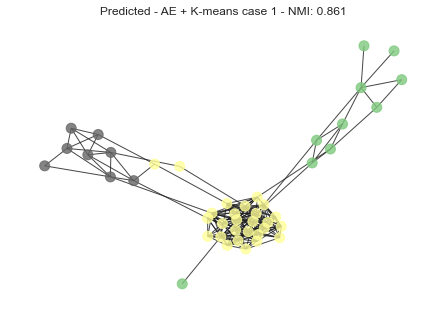

In [18]:
NMI = normalized_mutual_info_score(np.array(list(partition_true.values())), np.array(list(partition_predicted.values())))
Plotting.graph_cluster_plot(g=g, partition=partition_predicted, title='Predicted - AE + K-means case 1 - NMI: ' + str(np.round(NMI, 3)))

In [ ]:
# CASE 1
g = Utils.unpickle_object(data_folder + files[1])

#Preprocessing
X = np.asarray(nx.to_numpy_matrix(g))
partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster}
Y = np.array(list(partition_true.values()))
k = len(np.unique(Y))

#Wine dataset: Original Implementation
'''
from sklearn.datasets import load_wine
from sklearn import preprocessing

data = load_wine()
X = data.data
Y = data.target
k = len(np.unique(Y))

min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
'''

S = cosine_similarity(X, X)


#Should this be X.sum or S.sum ? From Github Implementation
D = np.diag(1.0 / np.sqrt(S.sum(axis=1)))
X_train = torch.tensor(D.dot(S).dot(D)).float().to(device)

#My Reading of the Paper
'''
D = np.diag(X.sum(axis=1))
X_train = np.linalg.inv(D) @ S
X_train = torch.tensor(X_train).float().to(device)
'''


epochs = 500
beta = 0   #Unregularized works best. Maybe the KL divergence implementation is flawed
rho = 0.5 #paper had 0.01
lr = 1e-4

#First cycle
layers = [len(X_train)] + [512, 256, 512] + [len(X_train)]
model = GraphEncoder(layers, k).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

#Train first cycle
with tqdm(total=epochs) as tq:
  for epoch in range(1, epochs + 1):
    optimizer.zero_grad()
    X_hat = model(X_train)
    loss = model.loss(X_hat, X_train, beta, rho)
    nmi = normalized_mutual_info_score(model.get_cluster(random_state=SEED), Y, average_method='arithmetic')
    loss.backward()
    optimizer.step()
    tq.set_postfix(loss='{:.3f}'.format(loss), nmi='{:.3f}'.format(nmi))
    tq.update()

embedding = model.outputs['lin2']

partition_true = g.graph['partition']
partition_true = {node:i for i, cluster in enumerate(partition_true) for node in cluster}
partition_predicted = model.get_cluster(random_state=SEED)
partition_predicted = {node: comm for node, comm in zip(list(partition_true.keys()), partition_predicted)}

  0%|          | 0/500 [00:00<?, ?it/s]